# Circle

Distribute $n$ variables uniformly randomly around a circle then generate $m$ clauses of $a$ variables each where each clause has a random "center" point on the circle from which all variables in the clause must be within a certain distance $w$.

Observe the time taken to solve instances of different $w$.

In [28]:
import os
# parameters
a = os.getenv('SL_A', 10)
m = os.getenv('SL_M', 1000)
n = os.getenv('SL_N', 100)
print('a: {}, m: {}, n: {}'.format(a, m, n))

a: 10, m: 1000, n: 100


In [29]:
! [ -d data ] || mkdir data

In [30]:
import numpy as np
W = np.linspace(0.1, 0.5, num=16)
with open("data/w.txt", "w") as f:
    for w in W:
        print(w, file=f)
print(W)

[ 0.1         0.12666667  0.15333333  0.18        0.20666667  0.23333333
  0.26        0.28666667  0.31333333  0.34        0.36666667  0.39333333
  0.42        0.44666667  0.47333333  0.5       ]


## Generate instances

In [31]:
%%time
%%bash -s "$a" "$m" "$n"
cat data/w.txt | parallel sl -n "$3" -m "$2" -a "$1" -w "{}" -o "data/instance-{}.cnf" -q

CPU times: user 4.03 ms, sys: 10.3 ms, total: 14.3 ms
Wall time: 2.41 s


In [32]:
%ls

Circle.ipynb  data/


In [33]:
! head data/instance-0.1.cnf

c generator: circle
c k: 10
c w: 0.1
p cnf 100 1000
76 80 -69 72 70 -86 73 -79 78 83 0
-63 68 60 73 -76 -64 70 71 67 -75 0
14 -21 22 20 11 16 -13 -23 -10 18 0
-30 -24 21 -18 20 17 -19 22 31 32 0
-17 12 16 15 5 -2 -13 -3 -7 8 0
64 75 69 -66 -72 -71 -60 -76 -58 -77 0


## Solve

In [34]:
%%time
%%bash
for w in $(cat data/w.txt); do 
    cat data/instance-${w}.cnf | docker run --rm -i msoos/cryptominisat:v2 > data/result-${w}.out
done

CPU times: user 4.32 ms, sys: 13.7 ms, total: 18 ms
Wall time: 27 s


In [35]:
%ls data

instance-0.1.cnf             result-0.126666666667.out
instance-0.126666666667.cnf  result-0.153333333333.out
instance-0.153333333333.cnf  result-0.18.out
instance-0.18.cnf            result-0.206666666667.out
instance-0.206666666667.cnf  result-0.233333333333.out
instance-0.233333333333.cnf  result-0.26.out
instance-0.26.cnf            result-0.286666666667.out
instance-0.286666666667.cnf  result-0.313333333333.out
instance-0.313333333333.cnf  result-0.34.out
instance-0.34.cnf            result-0.366666666667.out
instance-0.366666666667.cnf  result-0.393333333333.out
instance-0.393333333333.cnf  result-0.42.out
instance-0.42.cnf            result-0.446666666667.out
instance-0.446666666667.cnf  result-0.473333333333.out
instance-0.473333333333.cnf  result-0.5.out
instance-0.5.cnf             w.txt
result-0.1.out


## Analyze

In [36]:
%%bash
for w in $(cat data/w.txt); do
    printf "${w},"
    cat data/result-${w}.out | grep 'Total time' | sed 's/[^0-9\.]//g' | xargs echo -n
    printf ","
    cat data/result-${w}.out | grep '^s' | cut -d' ' -f 2 | sed 's/ISFIABLE//'
done | sort > data/times.tsv

In [37]:
import pandas as pd

pd.read_csv("data/times.tsv", names=['w','time','result']).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
w,0.1,0.126667,0.153333,0.18,0.206667,0.233333,0.26,0.286667,0.313333,0.34,0.366667,0.393333,0.42,0.446667,0.473333,0.5
time,0.06,0.04,0.03,0.04,0.03,0.03,0.03,0.04,0.02,0.04,0.03,0.03,0.04,0.03,0.04,0.04
result,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT,SAT


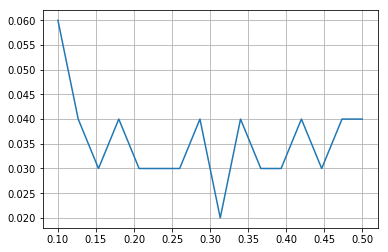

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('data/times.tsv', header=None)
W = data[:][0]
T = data[:][1]

fig, ax = plt.subplots(1, 1)

ax.plot(W, T, zorder=10)
ax.grid(True, zorder=5)
plt.show()